,lookback_periods,number_of_positions,holding_period,long_only,sharpe_ratio
0,"[1, 2, 3, 4, 5, 6]",5,12,False,8.960567
1,"[1, 2, 3, 4, 5, 6]",5,12,True,8.960567
2,"[1, 2, 3, 4]",5,12,False,7.992479
3,"[1, 2, 3, 4]",5,12,True,7.992479
4,"[1, 2, 3, 4, 5, 6]",10,12,False,7.604070
5,"[1, 2, 3, 4, 5, 6]",10,12,True,7.604070
6,"[1, 2, 3]",5,12,True,7.532662
7,"[1, 2, 3]",5,12,False,7.532662
8,"[1, 2, 3, 4]",10,12,False,7.067074
9,"[1, 2, 3, 4]",10,12,True,7.067074


Best Parameter Set:
Lookback Periods: [1, 2, 3, 4, 5, 6]
Number of Positions: 5
Holding Period: 12
Long Only: True
Best Sharpe Ratio: 8.960566537499385


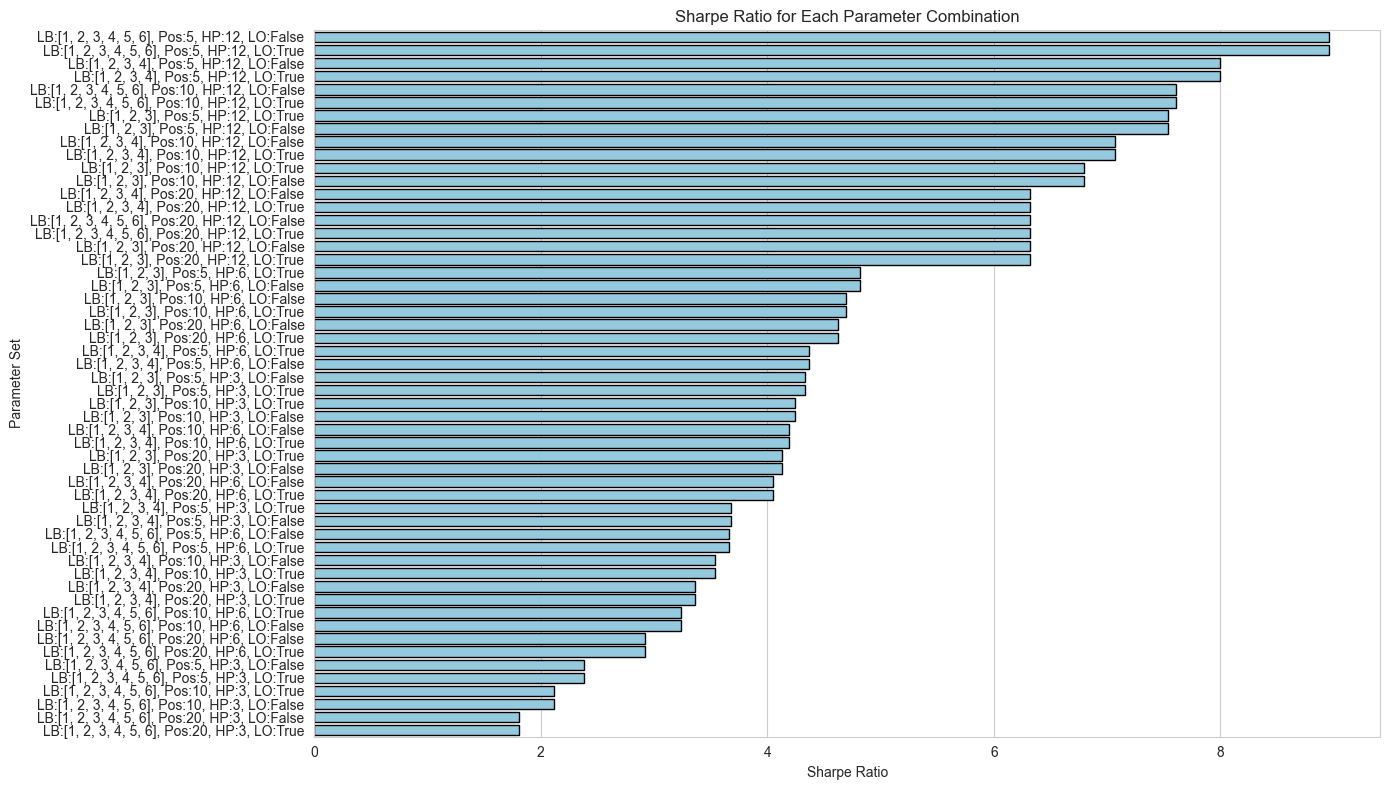

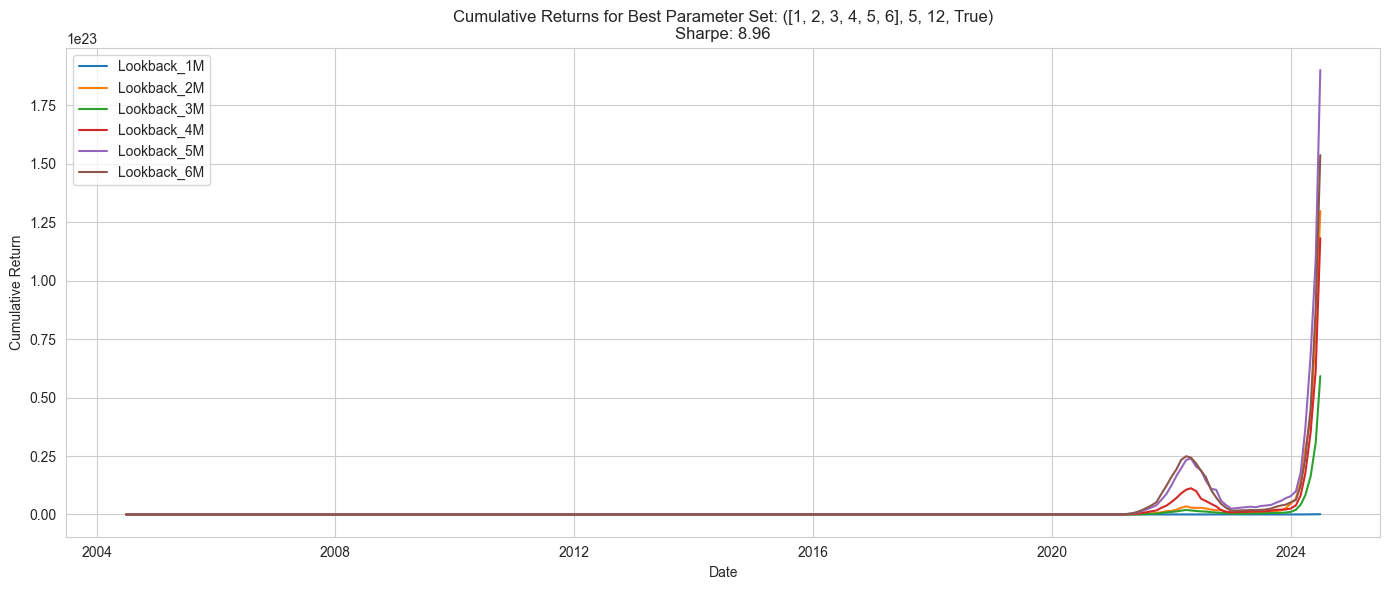

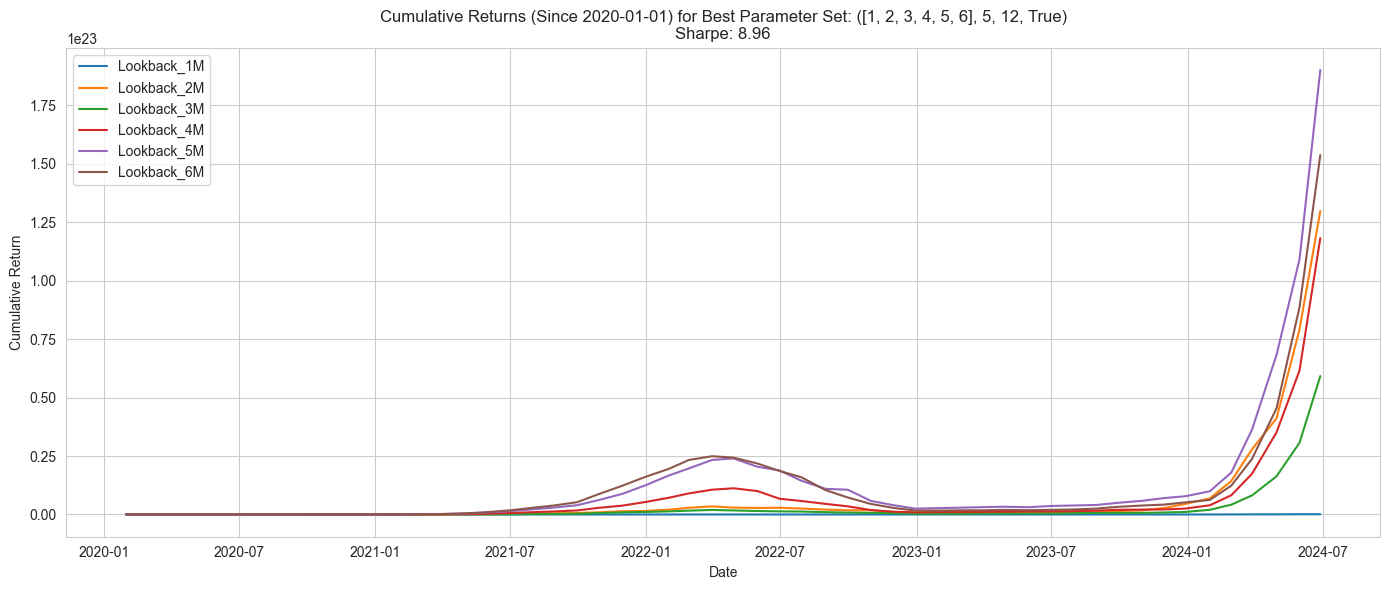

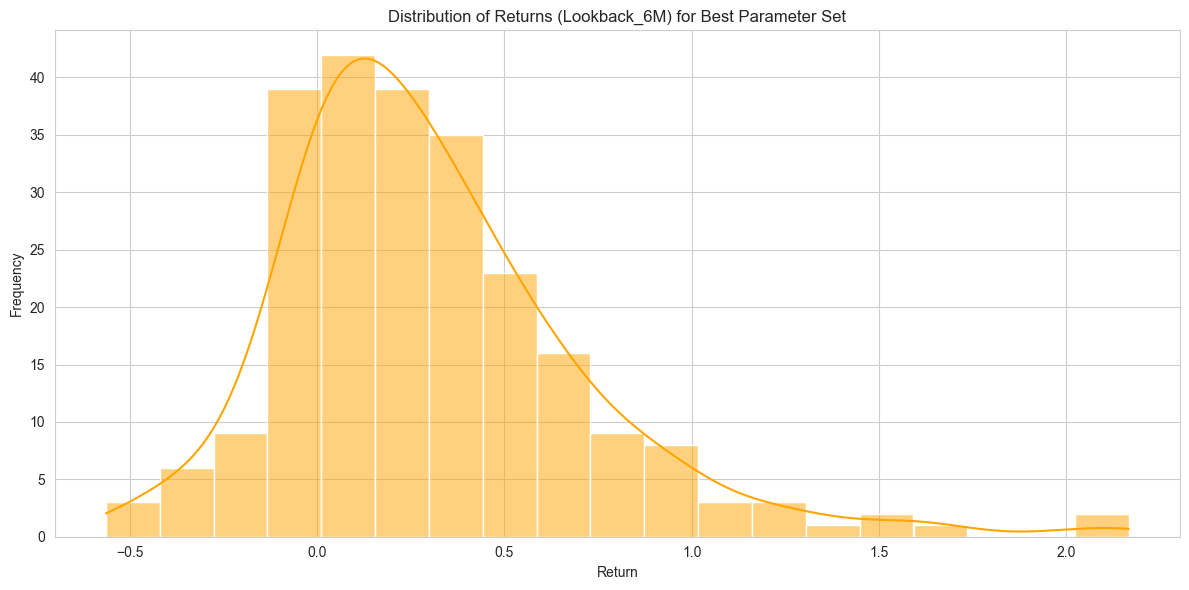

In [5]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we can find the project modules
sys.path.append(os.path.abspath('../src/features'))

from portfolio_construction import signal_calculation
from variables import (
    path_portfolio_performances,
    path_stock_returns_holding_period,
    path_stock_returns_signal,
    path_stock_weights
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Define parameter ranges
lookback_periods_list = [
    [1, 2, 3],
    [1, 2, 3, 4],
    [1, 2, 3, 4, 5, 6]
]

number_of_positions_list = [5, 10, 20]
holding_period_list = [3, 6, 12]
long_only_list = [True, False]  # Evaluate both long-only and long-short

# Risk-free rate for Sharpe ratio
risk_free_rate = 0.012  # annualized 1.2%

def annualized_return(series, freq=12):
    if len(series) == 0:
        return np.nan
    cumulative_growth = (1 + series).prod()
    n_periods = len(series)
    return cumulative_growth**(freq / n_periods) - 1

def annualized_volatility(series, freq=12):
    if len(series) < 2:
        return np.nan
    return series.std() * np.sqrt(freq)

def sharpe_ratio(series, freq=12, risk_free=risk_free_rate):
    ann_ret = annualized_return(series, freq)
    ann_vol = annualized_volatility(series, freq)
    if ann_vol == 0 or np.isnan(ann_vol):
        return np.nan
    return (ann_ret - risk_free) / ann_vol

# Store results
results = []
best_sharpe = -np.inf
best_params = None
best_df_portfolio = None

# Iterate over all parameter combinations
for lookback_periods in lookback_periods_list:
    for number_of_positions in number_of_positions_list:
        for holding_period in holding_period_list:
            for long_only in long_only_list:
                # Run the signal calculation for these parameters
                # Note: This will overwrite previously generated HDF5 files.
                signal_calculation(lookback_periods, number_of_positions, holding_period, long_only)
                
                # Read the resulting portfolio performances
                try:
                    df_portfolio = pd.read_hdf(path_portfolio_performances, 'df')
                except FileNotFoundError:
                    # If no file found, skip this iteration
                    continue

                # Compute Sharpe Ratios for each lookback column
                strategy_metrics = {}
                for col in df_portfolio.columns:
                    returns = df_portfolio[col].dropna()
                    sr = sharpe_ratio(returns)
                    strategy_metrics[col] = sr

                # Evaluate average Sharpe across all lookback columns
                average_sharpe = np.nanmean(list(strategy_metrics.values()))

                results.append({
                    'lookback_periods': lookback_periods,
                    'number_of_positions': number_of_positions,
                    'holding_period': holding_period,
                    'long_only': long_only,
                    'sharpe_ratio': average_sharpe
                })

                # Track best parameters
                if average_sharpe > best_sharpe:
                    best_sharpe = average_sharpe
                    best_params = (lookback_periods, number_of_positions, holding_period, long_only)
                    best_df_portfolio = df_portfolio.copy()

# Create a DataFrame of all results
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

# Display top 10 results
display(df_results.head(10))

print("Best Parameter Set:")
print("Lookback Periods:", best_params[0])
print("Number of Positions:", best_params[1])
print("Holding Period:", best_params[2])
print("Long Only:", best_params[3])
print("Best Sharpe Ratio:", best_sharpe)

# --- Visualization ---

# 1. Bar Plot of Sharpe Ratios for Each Parameter Combination
df_results['param_label'] = df_results.apply(
    lambda x: f"LB:{x.lookback_periods}, Pos:{x.number_of_positions}, HP:{x.holding_period}, LO:{x.long_only}", axis=1
)

plt.figure(figsize=(14, 8))
sns.barplot(x='sharpe_ratio', y='param_label', data=df_results, color='skyblue', edgecolor='black')
plt.title('Sharpe Ratio for Each Parameter Combination')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Parameter Set')
plt.tight_layout()
plt.show()

# 2. Plot Cumulative Returns for the Best Parameter Set (All Columns), Starting at 1
plt.figure(figsize=(14, 6))
for col in best_df_portfolio.columns:
    returns = best_df_portfolio[col].dropna()
    cumulative_returns = (1 + returns).cumprod()
    if not cumulative_returns.empty:
        # Rebase to start at 1
        cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]
        plt.plot(cumulative_returns.index, cumulative_returns, label=col)

plt.title(f'Cumulative Returns for Best Parameter Set: {best_params}\nSharpe: {best_sharpe:.2f}')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Cumulative Returns Over the Last Few Years
# Adjust the date range as needed
start_date = '2020-01-01'
plt.figure(figsize=(14, 6))
for col in best_df_portfolio.columns:
    returns = best_df_portfolio[col].dropna()
    cumulative_returns = (1 + returns).cumprod()
    if not cumulative_returns.empty:
        # Rebase to start at 1
        cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]
        # Filter for last few years
        recent_cumulative = cumulative_returns.loc[cumulative_returns.index >= start_date]
        plt.plot(recent_cumulative.index, recent_cumulative, label=col)

plt.title(f'Cumulative Returns (Since {start_date}) for Best Parameter Set: {best_params}\nSharpe: {best_sharpe:.2f}')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Distribution of Returns for One Strategy Column in Best Set
best_strat_col = best_df_portfolio.columns[-1]  # Pick the last column as an example
returns = best_df_portfolio[best_strat_col].dropna()

plt.figure(figsize=(12, 6))
sns.histplot(returns, kde=True, color='orange')
plt.title(f'Distribution of Returns ({best_strat_col}) for Best Parameter Set')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
